In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb


import os
import warnings

from pathlib import Path

#Configurations
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## Directories and Filenames
Contains paths and filenames to access test and training data.

In [7]:
ROOT_DIR = Path.cwd().parent
SRC_DIR = os.path.join(ROOT_DIR, 'src')
DATA_DIR = os.path.join(ROOT_DIR, 'data')

processed_training_data_path = os.path.join(DATA_DIR, 'train_processed.csv')
processed_test_data_path = os.path.join(DATA_DIR, 'test_processed.csv')

In [8]:
df_train = pd.read_csv(processed_training_data_path)
df_unseen_test = pd.read_csv(processed_test_data_path)

In [9]:
# x7_cols = [col for col in df_train.columns if col.startswith('x7_')]

# df_train_polka = df_train[df_train['x7_Polka'] == 1]
# df_train_polka = df_train_polka.drop(x7_cols, axis=1)

# df_train_slängpolskor = df_train[df_train['x7_Slängpolskor'] == 1]
# df_train_slängpolskor = df_train_slängpolskor.drop(x7_cols, axis=1)

# df_train_schottis = df_train[df_train['x7_Schottis'] == 1]
# df_train_schottis = df_train_schottis.drop(x7_cols, axis=1)

# df_train_polskor = df_train[(df_train['x7_Polskor'] == 1) | (df_train['x7_Slängpolskor'] == 1)]
# df_train_polskor = df_train_polskor.drop(x7_cols, axis=1)

# df_train_hambo = df_train[df_train['x7_Hambo'] == 1]
# df_train_hambo = df_train_hambo.drop(x7_cols, axis=1)

# df_train_x12_1 = df_train[df_train['x12_True'] == 1]
# df_train_x12_1 = df_train_x12_1.drop('x12_True', axis=1)

# df_train_x12_0 = df_train[df_train['x12_True'] == 0]
# df_train_x12_0 = df_train_x12_0.drop('x12_True', axis=1)

## Train, Validation and Test Splits & Modeling

In [10]:
df_test = df_train.sample(frac=0.2, random_state=42)
df_train = df_train.drop(df_test.index)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Unseen test shape: {df_unseen_test.shape}")

df_train.head()

Train shape: (790, 7)
Test shape: (197, 7)
Unseen test shape: (10000, 6)


,x4,x5,x8,x9,x10,x11,y
0,0.041297,0.168716,1.243974,0.323734,-0.275316,-0.462594,2
1,0.505788,-0.394709,-0.343594,-0.401810,-0.042394,0.763768,0
2,0.476071,-0.055452,0.888450,0.078986,-1.363136,-0.845952,1
3,0.279145,-0.166733,-0.935800,-0.617531,0.041439,-0.285398,2
4,0.952232,-1.010925,-1.471067,1.137805,0.408868,-0.852787,1


In [11]:
from catboost import CatBoostClassifier

def train_different_models(x_train, y_train):
    
    from sklearn.model_selection import GridSearchCV

    xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42, n_jobs=-1)

    xgb_parameters = {
        'n_estimators': [30, 50, 70, 100, 200, 300],
        'max_depth': [3, 5, 7, 8, 10, 15],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    }

    cb_model = CatBoostClassifier(random_state=42, verbose=False)

    # cb_parameters = {
    #     'iterations': [ 50, 100, 300],
    #     'depth': [5, 10, 15],
    #     'learning_rate': [0.01, 0.1, 0.2],
    # }


    #Define custom scoring function according to weighted f1 score for each class
    from sklearn.metrics import f1_score, make_scorer

    def weighted_f1_score(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    scoring = make_scorer(weighted_f1_score, greater_is_better=True)

    xgb_cv = GridSearchCV(xgb_model, xgb_parameters, cv=10, n_jobs=-1, scoring=scoring)
    xgb_cv.fit(x_train, y_train)

    #cb_cv = GridSearchCV(cb_model, cb_parameters, cv=5, n_jobs=-1, scoring=scoring, verbose=1)
    # cb_cv.fit(x_train, y_train)
    cb_model.fit(x_train, y_train)

    return xgb_cv, cb_model

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score

def evaluate_model(model_predictions, model_labels, model):
    fig, ax = plt.subplots(figsize=(12, 8))
    cm = confusion_matrix(model_labels, model_predictions)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.show()

    #print(classification_report(model_labels, model_predictions))
    #print(f"Weighted F1 Score across all classes: {f1_score(model_labels, model_predictions, average='weighted')}")
    return f1_score(model_labels, model_predictions, average='weighted')

def train_and_evaluate_different_models_for_splits(dataframes, labels, upsample = False):
    xgb_models = {}
    cb_models = {}
    f1_scores_xgb = {}
    f1_scores_cb = {}
    sample_sizes = []

    for name, df in zip(labels, dataframes):
        x_train, x_val, y_train, y_val = train_test_split(df.drop(['y'], axis=1), df['y'], test_size=0.2, random_state=42, stratify=df['y'])

        if upsample:
            x_train, y_train = upsample_training_data_with_SMOTE(x_train, y_train)

        sample_sizes.append(x_train.shape[0])

        xgb_model, cb_model = train_different_models(x_train, y_train)
        xgb_models[f"{name}_xgb"] = xgb_model
        cb_models[f"{name}_cb"] = cb_model

        xgb_predictions = xgb_model.predict(x_val)
        cb_predictions = cb_model.predict(x_val)

        f1_scores_xgb[f"{name}_xgb"] = evaluate_model(xgb_predictions, y_val, xgb_model)
        f1_scores_cb[f"{name}_cb"] = evaluate_model(cb_predictions, y_val, cb_model)
    
    
    weights = sample_sizes / np.sum(sample_sizes)
    print(f" Weighted overall f1_scores_xgb: {weights.dot(list(f1_scores_xgb.values())).mean()}")
    print(f" Weighted overall f1_scores_cb: {weights.dot(list(f1_scores_cb.values())).mean()}")

    return xgb_models, f1_scores_xgb, cb_models, f1_scores_cb

def upsample_training_data_with_SMOTE(x_train, y_train):
    from imblearn.over_sampling import SMOTE

    #print class distribution before SMOTE
    # print("Before SMOTE: ", y_train.value_counts())

    sm = SMOTE(random_state=42, n_jobs=-1)
    x_train, y_train = sm.fit_resample(x_train, y_train)

    #print class distribution after SMOTE
    # print("After SMOTE: ", y_train.value_counts())

    return x_train, y_train

In [13]:
#Train and evaluate separate models
# data_by_x5 = [df_train_polka, df_train_schottis, df_train_polskor, df_train_hambo]

# labels = ['Polka', 'Schottis', 'Polskor', 'Hambo']

# xgb_models, f1_xgb = train_and_evaluate_different_models_for_splits(data_by_x5, labels, upsample=True)
# f1_xgb

In [14]:
# df_train_slängpolskor = df_train[df_train['x7_Slängpolskor'] == 1]
# df_train_slängpolskor = df_train_slängpolskor.drop(x7_cols, axis=1)

# df_train_polskor = df_train[(df_train['x7_Polskor'] == 1) | (df_train['x7_Slängpolskor'] == 1)]
# df_train_polskor = df_train_polskor.drop(x7_cols, axis=1)


# data_by_x5 = [df_train_polka, df_train_schottis, df_train_slängpolskor, df_train_polskor, df_train_hambo]

# labels = ['Polka', 'Schottis', 'Slängpolskor', 'Polskor', 'Hambo']

# xgb_models, f1_xgb = train_and_evaluate_different_models_for_splits(data_by_x5, labels, upsample=True)

In [15]:
# x12_dfs = [df_train_x12_1, df_train_x12_0]
# x12_labels = ['x12_True', 'x12_False']

# xgb_models_x12 = train_and_evaluate_different_models_for_splits(x12_dfs, x12_labels)

[12:56:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


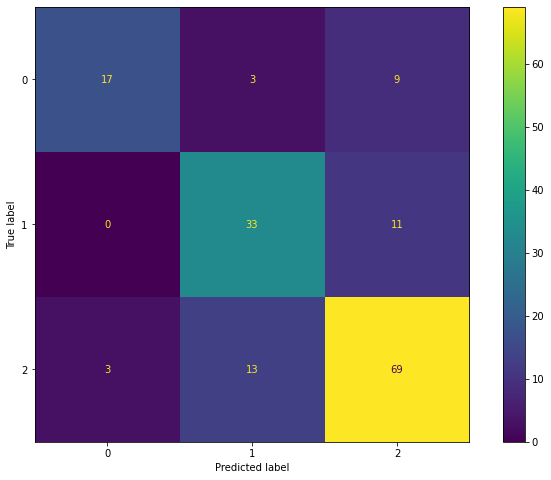

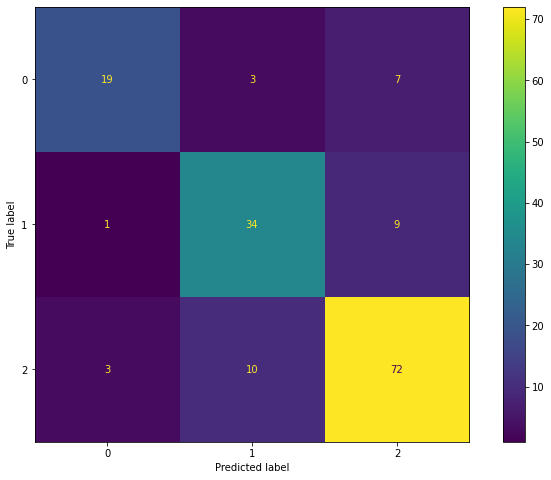

 Weighted overall f1_scores_xgb: 0.7516585350294493
 Weighted overall f1_scores_cb: 0.7900181877097074


In [16]:
xgb_model_all, f1_xgb_all, cb_model_all, f1_cb_all = train_and_evaluate_different_models_for_splits([df_train], ['All'])

In [76]:
xgb_model_all_us, f1_xgb_all_us, cb_model_all_us, f1_cb_all_us = train_and_evaluate_different_models_for_splits([df_train], ['All'], upsample=True)

Before SMOTE:  2    341
1    175
0    116
Name: y, dtype: int64
After SMOTE:  1    341
2    341
0    341
Name: y, dtype: int64


KeyboardInterrupt: 

In [62]:
def evaluate_performance_on_test_set(model, df_test):
    x_test = df_test.drop(['y'], axis=1)
    y_test = df_test['y']

    predictions = model.predict(x_test)

    f1_score = evaluate_model(predictions, y_test, model)

    return f1_score

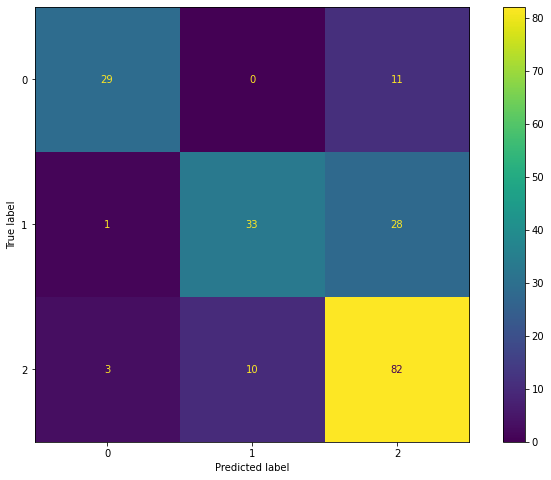

0.7252887315678498

In [77]:
evaluate_performance_on_test_set(xgb_model_all['All_xgb'], df_test)

In [119]:
# evaluate_performance_on_test_set(cb_model_all_us['All_cb'], df_test)

## CatBoost Parameter Tuning



In [138]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import optuna

In [152]:
def objective(trial,data=df_train.drop(['y'], axis=1), target= df_train['y']):

    param = {
        # "objective": trial.suggest_categorical("objective", ["Logloss","MultiClassOneVsAll", "MultiClass"]),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        # "depth": trial.suggest_int("depth", 1, 5),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
        "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }
    
    # if param["bootstrap_type"] == "Bayesian":
    #     param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    # elif param["bootstrap_type"] == "Bernoulli":
    #     param["subsample"] = trial.suggest_float("subsample", 0.1, 1)



        
    # Set up a kfold test
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    f1_scores = []
    for train_index, test_index in kf.split(data):
        x_train, x_val = data.iloc[train_index], data.iloc[test_index]
        y_train, y_val = target.iloc[train_index], target.iloc[test_index]

        # Upsample training data
        x_train, y_train = upsample_training_data_with_SMOTE(x_train, y_train)
        
        model = CatBoostClassifier(**param)  
        model.fit(x_train,y_train,eval_set=[(x_val, y_val)], verbose=0, early_stopping_rounds=100)
        preds = model.predict(x_val)

        f1_scores.append(f1_score(y_val, preds, average='weighted'))

    ## Full model
    # Split and upsample
    # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)
    # train_x, train_y = upsample_training_data_with_SMOTE(train_x, train_y)
    # model = CatBoostClassifier(**param)  
    # model.fit(train_x,train_y,eval_set=[(test_x, test_y)], verbose=0, early_stopping_rounds=100)
    # preds = model.predict(test_x)

    f1_wei = np.mean(f1_scores)

    return f1_wei

In [153]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-06-13 15:27:15,896] A new study created in memory with name: no-name-7ec0e133-564d-4084-ad16-9cd346e2842f
[I 2023-06-13 15:27:22,924] Trial 0 finished with value: 0.7580781359037435 and parameters: {'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.7580781359037435.
[I 2023-06-13 15:27:29,133] Trial 1 finished with value: 0.7595666435007894 and parameters: {'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.7595666435007894.
[I 2023-06-13 15:27:37,653] Trial 2 finished with value: 0.7580781359037435 and parameters: {'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.7595666435007894.
[I 2023-06-13 15:28:00,487] Trial 3 finished with value: 0.761169737117795 and parameters: {'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 3 with value: 0.761169737117795.
[I 2023-06-13 15:28:07,629] Trial 4 finished with value: 0.7580781359037435 and parameters: 

Number of finished trials: 10
Best trial: {'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [154]:
optuna.visualization.plot_param_importances(study)

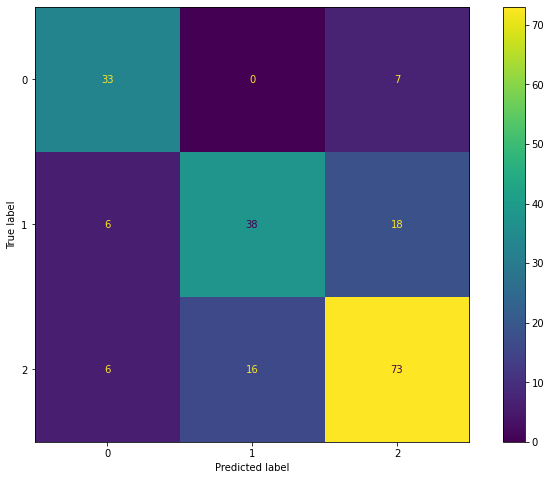

0.728653797759784

In [155]:
model = CatBoostClassifier(verbose=0)
x_train, y_train = upsample_training_data_with_SMOTE(df_train.drop(['y'], axis=1), df_train['y'])
# x_train,y_train = df_train.drop(['y'], axis=1), df_train['y']
model.fit(x_train, y_train)
evaluate_performance_on_test_set(model, df_test)

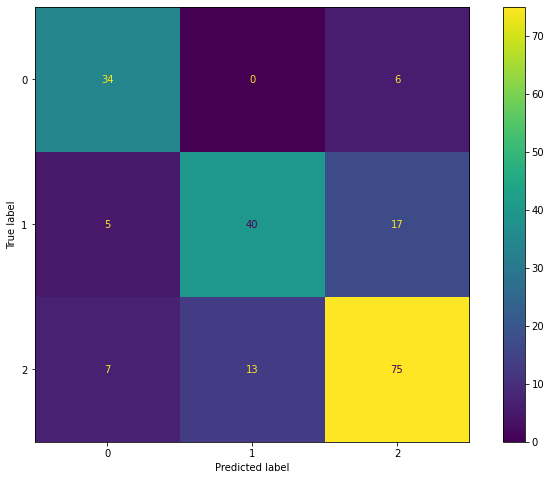

0.7542768459418508

In [157]:
model = CatBoostClassifier(**study.best_trial.params, verbose=0)
# model = CatBoostClassifier(verbose=0, boosting_type= 'Plain', bootstrap_type= 'MVS')
x_train, y_train = upsample_training_data_with_SMOTE(df_train.drop(['y'], axis=1), df_train['y'])
# x_train,y_train = df_train.drop(['y'], axis=1), df_train['y']
model.fit(x_train, y_train)
evaluate_performance_on_test_set(model, df_test)